# Comparing ERA5 and 449MHz profiler data (from Zarr)
The previous workflow that compared these datasets involved: 1. Programatically downloading ERA5 reanalysis data from the Copernicus Data Store (CDS) using the CDS API; 2. Manually downloading the 449 MHz Profiler data from EOL's Field Data Archive, then untarring and unzipping the files in the command line; 3. Using xarray, iteratively reading in individual netcdf files, standardizing them to follow the same conventions and concatenating them along variable and time dimensions.

The new workflow involves: 1. 

### Imports

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
lustre_scratch  = "/lustre/desc1/scratch/myasears"

### Read in zarr stores

In [2]:
era5_test_zarr = xr.open_zarr(f"{lustre_scratch}/2023_M2HATS/era5_M2HATS_ISS1_heights.zarr")
prof449Mhz_test_zarr = xr.open_zarr(f"{lustre_scratch}/2023_M2HATS/prof449_M2HATS_ISS1_winds30.zarr")

### Interpolate datasets to the same grid
We want an hourly time grid + a 200m height grid. ERA5 is on time, but not height; prof449 is on height, but not time. 

#### 449 interpolation

In [3]:
# Interpolate the ERA5 dataset onto the 449 time grid
prof449_interp = prof449Mhz_test_zarr.interp(time=era5_test_zarr['time'])

#### ERA5 interpolation
Completed in pre-processing; Zarr file is in terms of height coordinates, instead of pressure levels. 

### Combine datasets

### Visualize comparison
Visualize the differences between Profiler 449 data and ERA5 reanalysis data on the same height and time level for the entire M2HATS field campaign. 

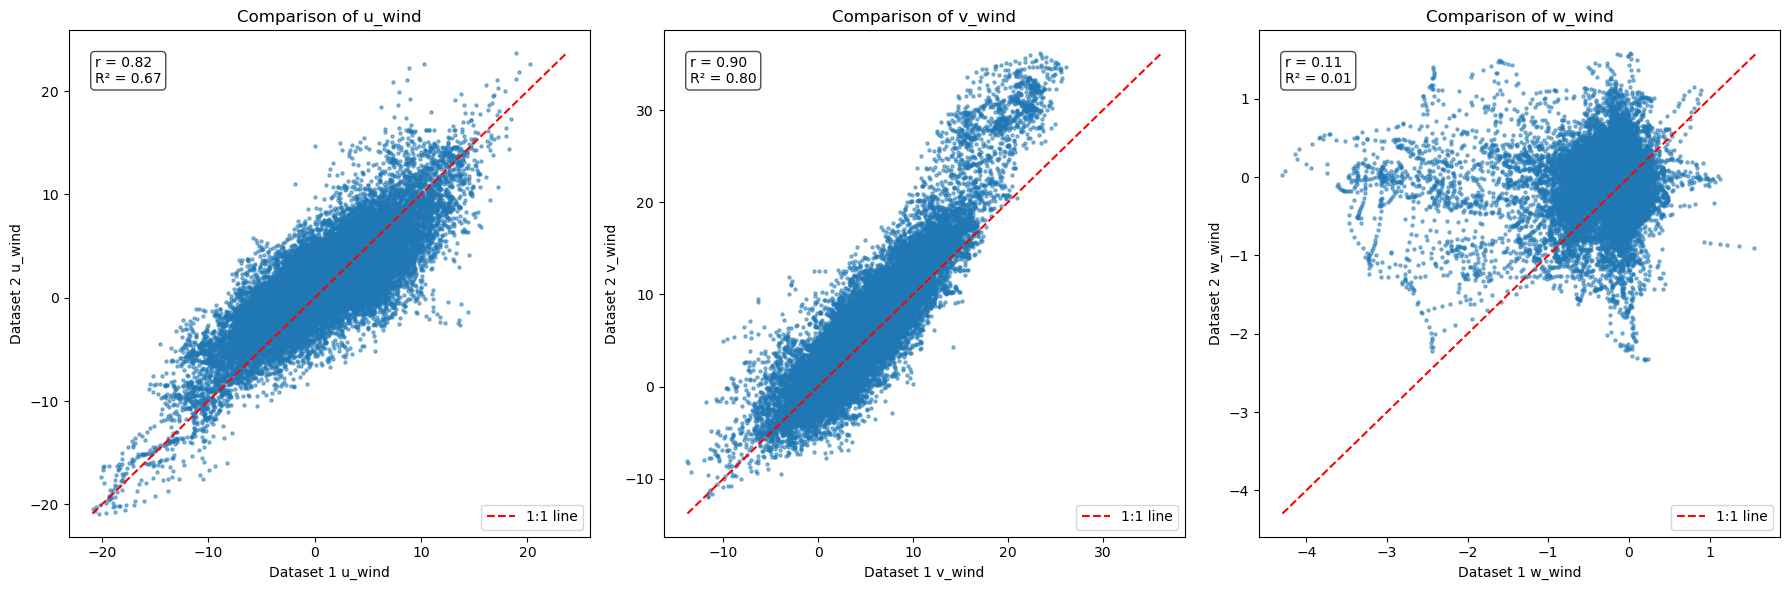

In [5]:
ds1 = prof449_interp
ds2 = era5_test_zarr

# Variables to compare
vars_to_compare = ["u_wind", "v_wind", "w_wind"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, var in zip(axes, vars_to_compare):
    # Extract values aligned on (time, height_msl)
    x = ds1[var].values.ravel()
    y = ds2[var].values.ravel()

    # Mask NaNs
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]

    # Scatter plot
    ax.scatter(x, y, s=5, alpha=0.5)

    # Add 1:1 reference line
    lims = [min(x.min(), y.min()), max(x.max(), y.max())]
    ax.plot(lims, lims, "r--", label="1:1 line")

    # Correlation and R²
    if len(x) > 1:
        r = np.corrcoef(x, y)[0, 1]
        r2 = r**2
        ax.text(
            0.05, 0.95,
            f"r = {r:.2f}\nR² = {r2:.2f}",
            transform=ax.transAxes,
            va="top", ha="left",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
        )

    ax.set_xlabel(f"Dataset 1 {var}")
    ax.set_ylabel(f"Dataset 2 {var}")
    ax.set_title(f"Comparison of {var}")
    ax.legend()

plt.tight_layout()
plt.show()

/glade/derecho/scratch/myasears/tmp/ipykernel_15073/3728170675.py:34: RuntimeWarning: Mean of empty slice
  mae_height = np.nanmean(err, axis=0)  # mean over time dimension


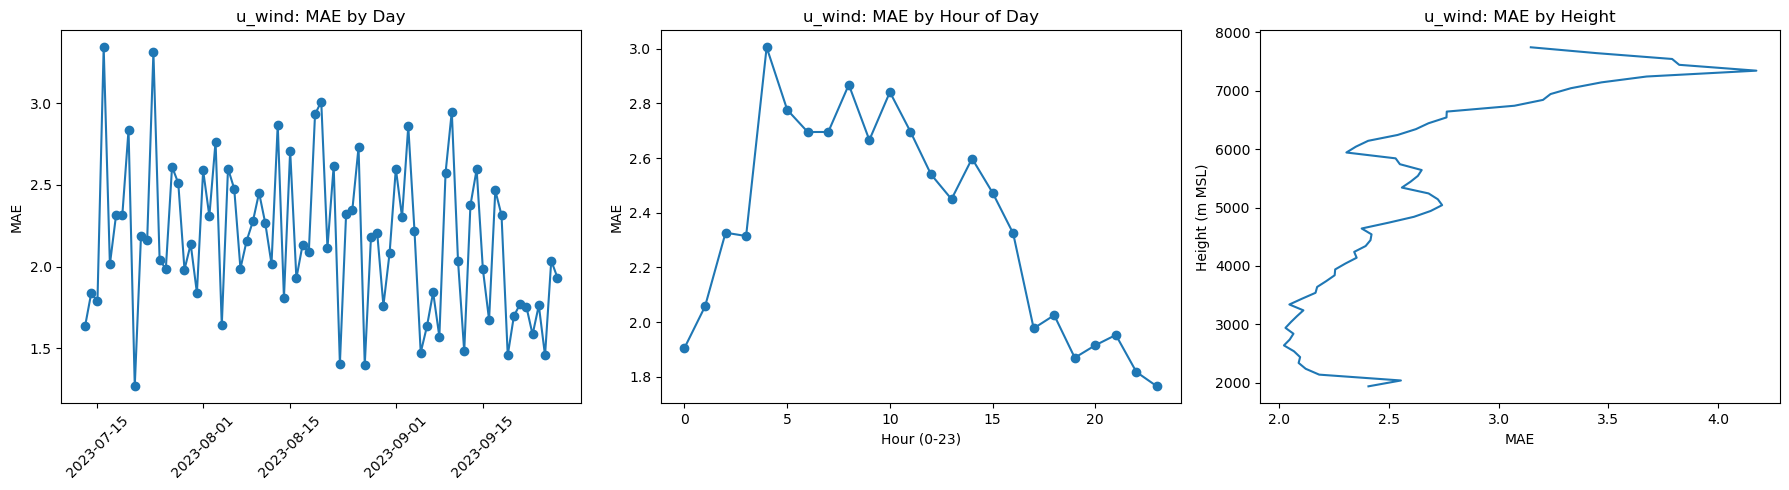

/glade/derecho/scratch/myasears/tmp/ipykernel_15073/3728170675.py:34: RuntimeWarning: Mean of empty slice
  mae_height = np.nanmean(err, axis=0)  # mean over time dimension


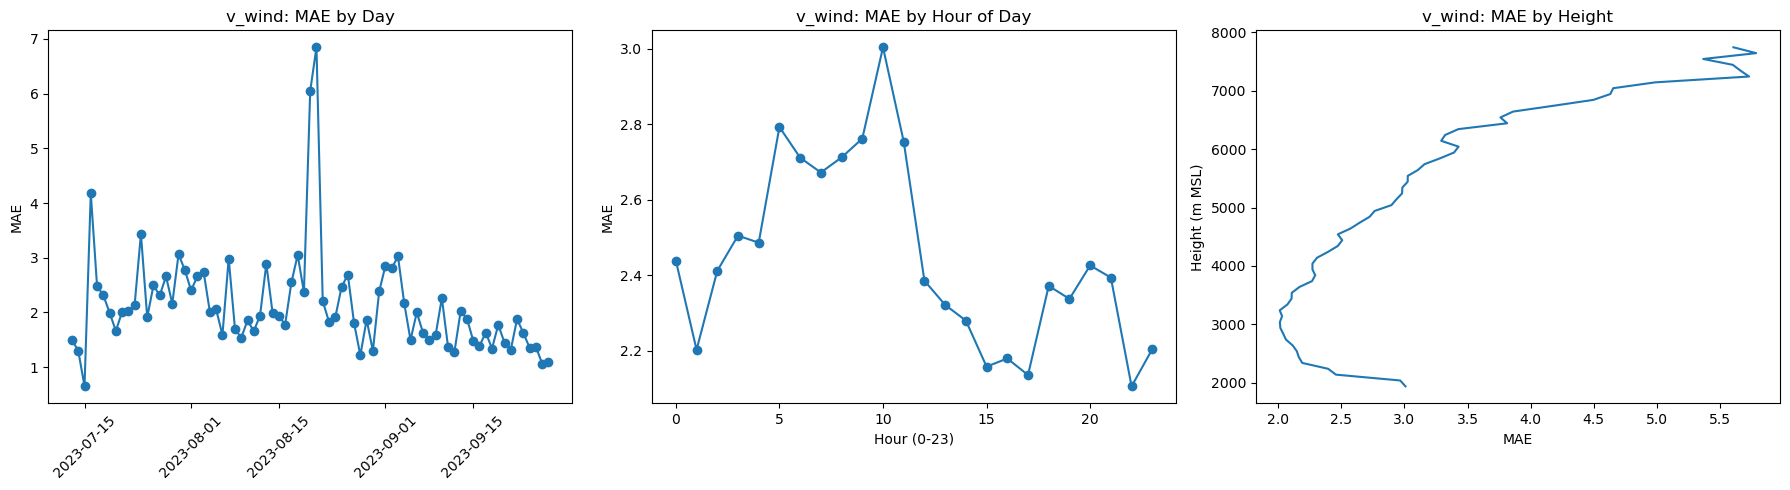

/glade/derecho/scratch/myasears/tmp/ipykernel_15073/3728170675.py:34: RuntimeWarning: Mean of empty slice
  mae_height = np.nanmean(err, axis=0)  # mean over time dimension


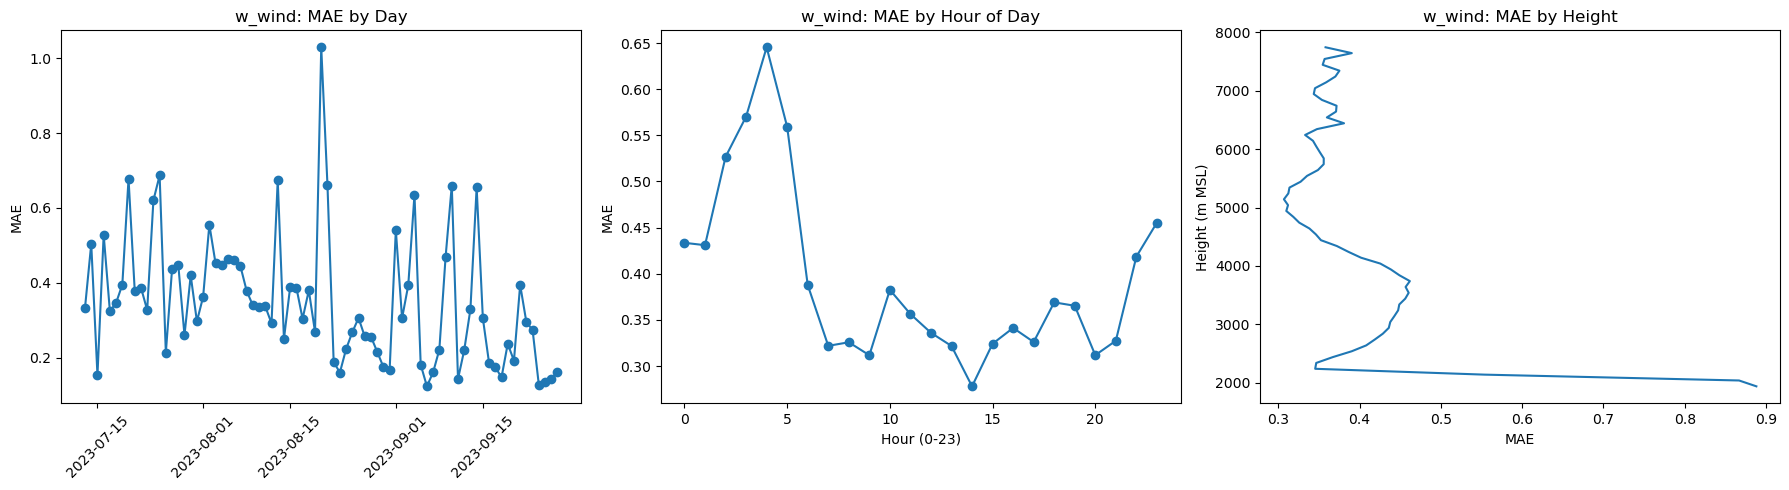

In [18]:
ds1 = prof449_interp
ds2 = era5_test_zarr

vars_to_compare = ["u_wind", "v_wind", "w_wind"]

for var in vars_to_compare:
    # Load arrays eagerly
    arr1 = ds1[var].values
    arr2 = ds2[var].values
    time = ds1["time"].values
    height = ds1["height_msl"].values

    # Compute absolute error (NumPy array)
    err = np.abs(arr1 - arr2)

    # --- (1) Daily MAE ---
    # collapse height dimension, then average by day
    df_daily = pd.DataFrame({
        "time": np.repeat(time, len(height)),
        "err": err.reshape(len(time) * len(height)),
    })
    df_daily["day"] = pd.to_datetime(df_daily["time"]).dt.date
    mae_daily = df_daily.groupby("day")["err"].mean()

    # --- (2) Hour-of-day MAE ---
    df_daily["hour"] = pd.to_datetime(df_daily["time"]).dt.hour
    mae_hourly = df_daily.groupby("hour")["err"].mean()

    # --- (3) Height MAE ---
    mae_height = np.nanmean(err, axis=0)  # mean over time dimension

    # --- Plot ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Daily
    axes[0].plot(mae_daily.index, mae_daily.values, marker="o")
    axes[0].set_title(f"{var}: MAE by Day")
    axes[0].set_ylabel("MAE")
    axes[0].tick_params(axis="x", rotation=45)

    # Hour-of-day
    axes[1].plot(mae_hourly.index, mae_hourly.values, marker="o")
    axes[1].set_title(f"{var}: MAE by Hour of Day")
    axes[1].set_xlabel("Hour (0-23)")
    axes[1].set_ylabel("MAE")

    # Height
    axes[2].plot(mae_height, height)
    axes[2].set_title(f"{var}: MAE by Height")
    axes[2].set_xlabel("MAE")
    axes[2].set_ylabel("Height (m MSL)")

    plt.tight_layout()
    plt.show()
